In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import os, json, math, random, re
from glob import glob
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, get_linear_schedule_with_warmup
from sentence_transformers import SentenceTransformer, util as st_util
from tqdm.auto import tqdm
from torch.amp import autocast, GradScaler

# =========================
# 0) Setup
# =========================
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)
if device == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    try: torch.set_float32_matmul_precision("high")
    except Exception: pass

AMP_DTYPE = torch.bfloat16 if (device == "cuda") else torch.float32
print("AMP_DTYPE:", AMP_DTYPE)
scaler = GradScaler("cuda", enabled=(device=="cuda" and AMP_DTYPE==torch.float16))

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if device == "cuda":
    torch.cuda.manual_seed_all(42)

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# =========================
# 1) Paths
# =========================
OUT_DIR = "/content/drive/MyDrive/DiffPriv/Enron"
RAW_LM_JSON_OUT = f"{OUT_DIR}/enron_raw_lm.json"
EMBED_JSON_OUT  = f"{OUT_DIR}/enron_email_embed.json"
assert os.path.exists(RAW_LM_JSON_OUT), f"Missing {RAW_LM_JSON_OUT}"
assert os.path.exists(EMBED_JSON_OUT),  f"Missing {EMBED_JSON_OUT}"

# New “fixed” model dirs (won’t overwrite your old ones)
SAVE_DIR_LM      = f"{OUT_DIR}/Models/gpt2_lm_FIXED"
SAVE_DIR_ADAPTER = f"{OUT_DIR}/Models/gpt2_prefix_adapter_FIXED"
os.makedirs(SAVE_DIR_LM, exist_ok=True)
os.makedirs(SAVE_DIR_ADAPTER, exist_ok=True)
adapter_path = os.path.join(SAVE_DIR_ADAPTER, "adapter.pt")

# =========================
# 2) Config (more compute)
# =========================
BASE_LM_NAME = "gpt2-medium"   # if you want max juice: try "gpt2-large"
EMBED_MODEL_NAME = "sentence-transformers/all-mpnet-base-v2"  # stronger than MiniLM

LM_MAX_SEQ_LEN  = 256
LM_BATCH_SIZE   = 8
LM_NUM_EPOCHS   = 3
LM_LR           = 5e-5
LM_GRAD_ACCUM   = 2

PREFIX_LEN = 20               # BIG win vs 1 token
MAX_ADAPTER_SEQ_LEN = 256
ADAPTER_BATCH_SIZE  = 16
ADAPTER_NUM_EPOCHS  = 12
ADAPTER_LR          = 2e-4

# DP knobs (keep sigma list later)
MAX_EMB_NORM_PERCENTILE = 0.90  # compute from data (better than hard 1.0)

# Generation knobs (make it faithful)
GEN_MAX_NEW_TOKENS = 96
GEN_MIN_NEW_TOKENS = 40
GEN_NUM_BEAMS = 4
GEN_NO_REPEAT_NGRAM = 3

# =========================
# 3) Load texts
# =========================
def load_texts_from_json(path, text_key="text", max_items=None):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    texts = []
    if isinstance(data, list):
        for rec in data:
            if isinstance(rec, dict) and isinstance(rec.get(text_key), str):
                texts.append(rec[text_key])
    if max_items is not None:
        texts = texts[:max_items]
    return texts

lm_texts = load_texts_from_json(RAW_LM_JSON_OUT, text_key="text")
print("LM texts:", len(lm_texts))

with open(EMBED_JSON_OUT, "r", encoding="utf-8") as f:
    embed_records = json.load(f)
assert isinstance(embed_records, list)

embed_texts = []
for r in embed_records:
    if not isinstance(r, dict):
        continue
    t = r.get("body_text") or r.get("Original Text") or ""
    if isinstance(t, str) and t.strip():
        embed_texts.append(t.strip())
embed_texts = embed_texts[:2000]
print("Adapter texts:", len(embed_texts))

# =========================
# 4) Tokenizer
# =========================
tokenizer = GPT2TokenizerFast.from_pretrained(BASE_LM_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# =========================
# 5) LM dataset + TRAIN (FIX: mask padding in labels)
# =========================
class LMTextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length):
        self.enc = tokenizer(
            texts,
            truncation=True,
            max_length=max_length,
            padding="max_length",
            return_tensors="pt",
        )
    def __len__(self):
        return self.enc["input_ids"].size(0)
    def __getitem__(self, idx):
        input_ids = self.enc["input_ids"][idx]
        attention_mask = self.enc["attention_mask"][idx]
        labels = input_ids.clone()
        labels[attention_mask == 0] = -100  # ✅ DO NOT TRAIN ON PADDING
        return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

lm_dataset = LMTextDataset(lm_texts, tokenizer, LM_MAX_SEQ_LEN)
val_size = max(1, int(0.1 * len(lm_dataset)))
train_size = len(lm_dataset) - val_size
lm_train, lm_val = random_split(lm_dataset, [train_size, val_size])

# ✅ Colab deadlocks a lot with workers; keep it simple/reliable
lm_train_loader = DataLoader(lm_train, batch_size=LM_BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
lm_val_loader   = DataLoader(lm_val,   batch_size=LM_BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

gpt2_lm = GPT2LMHeadModel.from_pretrained(BASE_LM_NAME).to(device)
gpt2_lm.resize_token_embeddings(len(tokenizer))

optimizer = torch.optim.AdamW(gpt2_lm.parameters(), lr=LM_LR)
num_update_steps_per_epoch = math.ceil(len(lm_train_loader) / LM_GRAD_ACCUM)
num_training_steps = LM_NUM_EPOCHS * num_update_steps_per_epoch
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * num_training_steps),
    num_training_steps=num_training_steps
)

print("\n=== Training LM (FIXED padding labels) ===")
gpt2_lm.train()
for epoch in range(LM_NUM_EPOCHS):
    running = 0.0
    optimizer.zero_grad(set_to_none=True)
    pbar = tqdm(lm_train_loader, desc=f"LM Epoch {epoch+1}/{LM_NUM_EPOCHS}")
    for step, batch in enumerate(pbar):
        input_ids = batch["input_ids"].to(device, non_blocking=True)
        attention_mask = batch["attention_mask"].to(device, non_blocking=True)
        labels = batch["labels"].to(device, non_blocking=True)

        with autocast(device_type="cuda", dtype=AMP_DTYPE, enabled=(device=="cuda")):
            out = gpt2_lm(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = out.loss / LM_GRAD_ACCUM

        if scaler.is_enabled():
            scaler.scale(loss).backward()
        else:
            loss.backward()

        if (step + 1) % LM_GRAD_ACCUM == 0:
            if scaler.is_enabled():
                scaler.step(optimizer); scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()

        running += float(loss.item()) * LM_GRAD_ACCUM
        pbar.set_postfix({"loss": running / (step + 1)})

    # val
    gpt2_lm.eval()
    vlosses = []
    with torch.no_grad():
        for batch in lm_val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            with autocast(device_type="cuda", dtype=AMP_DTYPE, enabled=(device=="cuda")):
                out = gpt2_lm(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            vlosses.append(float(out.loss.item()))
    print(f"Val loss epoch {epoch+1}: {np.mean(vlosses):.4f}")
    gpt2_lm.train()

gpt2_lm.save_pretrained(SAVE_DIR_LM)
tokenizer.save_pretrained(SAVE_DIR_LM)
print("Saved LM to:", SAVE_DIR_LM)

# =========================
# 6) Train embedding -> PREFIX_LEN soft prompt adapter
# =========================
print("\n=== Training adapter (soft prompt) ===")
tokenizer = GPT2TokenizerFast.from_pretrained(SAVE_DIR_LM)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

gpt2_base = GPT2LMHeadModel.from_pretrained(SAVE_DIR_LM).to(device)
gpt2_base.eval()
for p in gpt2_base.parameters():
    p.requires_grad = False

embed_model = SentenceTransformer(EMBED_MODEL_NAME, device=device)
embed_dim = embed_model.get_sentence_embedding_dimension()
hidden_size = gpt2_base.config.n_embd
print("embed_dim:", embed_dim, "hidden:", hidden_size, "PREFIX_LEN:", PREFIX_LEN)

# Precompute embeddings + choose MAX_EMB_NORM from data distribution
all_embs = []
bs = 128
for i in tqdm(range(0, len(embed_texts), bs), desc="Encoding embeddings"):
    batch = embed_texts[i:i+bs]
    em = embed_model.encode(batch, convert_to_tensor=True, show_progress_bar=False)
    all_embs.append(em.detach().cpu())
embeddings = torch.cat(all_embs, dim=0)

norms = torch.norm(embeddings, dim=1).numpy()
MAX_EMB_NORM = float(np.quantile(norms, MAX_EMB_NORM_PERCENTILE))
print(f"Embedding norms: mean={norms.mean():.3f} p90={np.quantile(norms,0.9):.3f} -> MAX_EMB_NORM={MAX_EMB_NORM:.3f}")

class EmbeddingTextDataset(Dataset):
    def __init__(self, embeddings, texts, tokenizer, max_length):
        assert len(embeddings) == len(texts)
        self.embeddings = embeddings
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            max_length=self.max_length,
            padding="max_length",
            return_tensors="pt",
        )
        input_ids = enc["input_ids"].squeeze(0)
        attention_mask = enc["attention_mask"].squeeze(0)
        labels = input_ids.clone()
        labels[attention_mask == 0] = -100  # ✅ IMPORTANT
        return {
            "embedding": self.embeddings[idx],
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
        }

adapter_dataset = EmbeddingTextDataset(embeddings, embed_texts, tokenizer, MAX_ADAPTER_SEQ_LEN)
val_size = max(1, int(0.1 * len(adapter_dataset)))
train_size = len(adapter_dataset) - val_size
adapter_train, adapter_val = random_split(adapter_dataset, [train_size, val_size])

train_loader = DataLoader(adapter_train, batch_size=ADAPTER_BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(adapter_val,   batch_size=ADAPTER_BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

class EmbeddingPrefixDecoder(nn.Module):
    def __init__(self, gpt2, embed_dim, hidden_size, prefix_len):
        super().__init__()
        self.gpt2 = gpt2
        self.prefix_len = prefix_len
        self.adapter = nn.Sequential(
            nn.Linear(embed_dim, hidden_size * prefix_len),
            nn.Tanh()
        )

    def forward(self, embeddings, input_ids, attention_mask, labels):
        B = embeddings.size(0)
        prefix = self.adapter(embeddings).view(B, self.prefix_len, -1)  # (B,K,H)

        tok_emb = self.gpt2.transformer.wte(input_ids)                  # (B,L,H)
        inputs_embeds = torch.cat([prefix, tok_emb], dim=1)             # (B,K+L,H)

        prefix_mask = torch.ones((B, self.prefix_len), device=attention_mask.device, dtype=attention_mask.dtype)
        ext_mask = torch.cat([prefix_mask, attention_mask], dim=1)

        labels_with_prefix = torch.full((B, labels.size(1) + self.prefix_len), -100, device=labels.device)
        labels_with_prefix[:, self.prefix_len:] = labels

        out = self.gpt2(inputs_embeds=inputs_embeds, attention_mask=ext_mask, labels=labels_with_prefix)
        return out.loss

model = EmbeddingPrefixDecoder(gpt2_base, embed_dim, hidden_size, PREFIX_LEN).to(device)
for p in model.gpt2.parameters(): p.requires_grad = False
for p in model.adapter.parameters(): p.requires_grad = True

opt = torch.optim.AdamW(model.adapter.parameters(), lr=ADAPTER_LR)

model.train()
for epoch in range(ADAPTER_NUM_EPOCHS):
    pbar = tqdm(train_loader, desc=f"Adapter Epoch {epoch+1}/{ADAPTER_NUM_EPOCHS}")
    for batch in pbar:
        emb = batch["embedding"].to(device, non_blocking=True)
        inp = batch["input_ids"].to(device, non_blocking=True)
        msk = batch["attention_mask"].to(device, non_blocking=True)
        lab = batch["labels"].to(device, non_blocking=True)

        opt.zero_grad(set_to_none=True)
        with autocast(device_type="cuda", dtype=AMP_DTYPE, enabled=(device=="cuda")):
            loss = model(emb, inp, msk, lab)

        if scaler.is_enabled():
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
        else:
            loss.backward()
            opt.step()

        pbar.set_postfix({"loss": float(loss.item())})

    # val
    model.eval()
    v = []
    with torch.no_grad():
        for batch in val_loader:
            emb = batch["embedding"].to(device)
            inp = batch["input_ids"].to(device)
            msk = batch["attention_mask"].to(device)
            lab = batch["labels"].to(device)
            with autocast(device_type="cuda", dtype=AMP_DTYPE, enabled=(device=="cuda")):
                vloss = model(emb, inp, msk, lab)
            v.append(float(vloss.item()))
    print(f"Adapter val loss epoch {epoch+1}: {np.mean(v):.4f}")
    model.train()

torch.save({
    "adapter_state_dict": model.adapter.state_dict(),
    "embed_dim": embed_dim,
    "hidden_size": hidden_size,
    "prefix_len": PREFIX_LEN,
    "gpt2_path": SAVE_DIR_LM,
    "embed_model_name": EMBED_MODEL_NAME,
    "max_emb_norm": MAX_EMB_NORM,
}, adapter_path)
print("Saved adapter to:", adapter_path)

# =========================
# 7) Generation + scoring (new CSVs)
# =========================
gpt2_gen = GPT2LMHeadModel.from_pretrained(SAVE_DIR_LM).to(device)
gpt2_gen.eval()

ckpt = torch.load(adapter_path, map_location=device)
embed_model = SentenceTransformer(ckpt["embed_model_name"], device=device)
PREFIX_LEN = int(ckpt["prefix_len"])
MAX_EMB_NORM = float(ckpt["max_emb_norm"])

adapter = nn.Sequential(
    nn.Linear(int(ckpt["embed_dim"]), int(ckpt["hidden_size"]) * PREFIX_LEN),
    nn.Tanh(),
).to(device)
adapter.load_state_dict(ckpt["adapter_state_dict"])
adapter.eval()

def clip_and_noise_norm(emb, max_norm, sigma):
    # norm clipping (not per-dimension clamp)
    norm = torch.norm(emb, dim=-1, keepdim=True)
    factor = torch.clamp(max_norm / (norm + 1e-8), max=1.0)
    clipped = emb * factor
    if sigma > 0:
        clipped = clipped + torch.randn_like(clipped) * sigma
    return clipped

@torch.no_grad()
def generate_from_text(text, sigma):
    # email-style anchor prompt (reduces "news" drift)
    prompt = "From: [REDACTED]\nTo: [REDACTED]\nSubject: "
    prompt_ids = tokenizer(prompt, return_tensors="pt")["input_ids"].to(device)
    prompt_emb = gpt2_gen.transformer.wte(prompt_ids)  # (1,P,H)

    emb = embed_model.encode([text], convert_to_tensor=True).to(device)
    emb = clip_and_noise_norm(emb, MAX_EMB_NORM, sigma=sigma)

    prefix = adapter(emb).view(1, PREFIX_LEN, -1)       # (1,K,H)
    inputs_embeds = torch.cat([prefix, prompt_emb], dim=1)

    attn = torch.ones((1, PREFIX_LEN + prompt_ids.size(1)), device=device, dtype=torch.long)

    out = gpt2_gen.generate(
        inputs_embeds=inputs_embeds,
        attention_mask=attn,
        max_new_tokens=GEN_MAX_NEW_TOKENS,
        min_new_tokens=GEN_MIN_NEW_TOKENS,
        do_sample=False,
        num_beams=GEN_NUM_BEAMS,
        no_repeat_ngram_size=GEN_NO_REPEAT_NGRAM,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )

    # drop prefix + prompt
    gen_ids = out[0, PREFIX_LEN + prompt_ids.size(1):]
    s = tokenizer.decode(gen_ids, skip_special_tokens=True).strip()
    return s

def jaccard_overlap(a, b):
    a_tokens = set((a or "").lower().split())
    b_tokens = set((b or "").lower().split())
    if not a_tokens and not b_tokens: return 1.0
    inter = len(a_tokens & b_tokens)
    union = len(a_tokens | b_tokens)
    return inter / union if union else 0.0

SIGMAS = [0.0, 0.005, 0.2, 0.5]
MAX_GEN_SAMPLES = 250
orig = embed_texts[:MAX_GEN_SAMPLES]
print("\nGenerating on:", len(orig), "samples | PREFIX_LEN:", PREFIX_LEN)

for sigma in SIGMAS:
    syn = []
    for t in tqdm(orig, desc=f"Generate σ={sigma}"):
        s = generate_from_text(t, sigma)
        # ultra simple fallback if still empty
        if not s:
            s = generate_from_text(t, sigma) or " "  # avoid empty -> NaN
        syn.append(s)

    rows = []
    for o, s in tqdm(list(zip(orig, syn)), desc=f"Score σ={sigma}"):
        jac = jaccard_overlap(o, s)
        eo = embed_model.encode(o, convert_to_tensor=True, device=device)
        es = embed_model.encode(s, convert_to_tensor=True, device=device)
        cos = float(st_util.cos_sim(eo, es)[0][0])
        rows.append({"original": o, "synthetic": s, "jaccard_overlap": jac, "embedding_cosine_similarity": cos})

    df = pd.DataFrame(rows)
    out_csv = f"{OUT_DIR}/metrics_sigma_{sigma}_FIXED.csv"
    df.to_csv(out_csv, index=False)
    empty_rate = float((df["synthetic"].astype(str).str.len() == 0).mean())
    print("Saved:", out_csv, "| empty_rate:", empty_rate, "| mean_cos:", df["embedding_cosine_similarity"].mean())

# Summary across sigmas
metric_files = sorted(glob(f"{OUT_DIR}/metrics_sigma_*_FIXED.csv"))
summ = []
for fp in metric_files:
    m = re.search(r"metrics_sigma_([0-9.]+)_FIXED\.csv$", os.path.basename(fp))
    sigma = float(m.group(1))
    df = pd.read_csv(fp, keep_default_na=False)
    df["syn_len"] = df["synthetic"].astype(str).str.len()
    summ.append({
        "sigma": sigma,
        "n": len(df),
        "mean_jaccard": float(df["jaccard_overlap"].mean()),
        "p50_jaccard": float(df["jaccard_overlap"].median()),
        "mean_cosine": float(df["embedding_cosine_similarity"].mean()),
        "p50_cosine": float(df["embedding_cosine_similarity"].median()),
        "empty_rate": float((df["syn_len"] == 0).mean()),
        "mean_syn_len": float(df["syn_len"].mean())
    })

summary = pd.DataFrame(summ).sort_values("sigma")
summary_path = f"{OUT_DIR}/summary_across_sigmas_FIXED.csv"
summary.to_csv(summary_path, index=False)
print("\nWrote:", summary_path)
display(summary)


Device: cuda
GPU: NVIDIA A100-SXM4-40GB
AMP_DTYPE: torch.bfloat16
LM texts: 30000
Adapter texts: 2000


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]


=== Training LM (FIXED padding labels) ===


LM Epoch 1/3:   0%|          | 0/3375 [00:00<?, ?it/s]

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Val loss epoch 1: 1.7286


LM Epoch 2/3:   0%|          | 0/3375 [00:00<?, ?it/s]

Val loss epoch 2: 1.6062


LM Epoch 3/3:   0%|          | 0/3375 [00:00<?, ?it/s]

Val loss epoch 3: 1.5701
Saved LM to: /content/drive/MyDrive/DiffPriv/Enron/Models/gpt2_lm_FIXED

=== Training adapter (soft prompt) ===


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

embed_dim: 768 hidden: 1024 PREFIX_LEN: 20


Encoding embeddings:   0%|          | 0/16 [00:00<?, ?it/s]

Embedding norms: mean=1.000 p90=1.000 -> MAX_EMB_NORM=1.000


Adapter Epoch 1/12:   0%|          | 0/113 [00:00<?, ?it/s]

Adapter val loss epoch 1: 1.6011


Adapter Epoch 2/12:   0%|          | 0/113 [00:00<?, ?it/s]

Adapter val loss epoch 2: 1.5911


Adapter Epoch 3/12:   0%|          | 0/113 [00:00<?, ?it/s]

Adapter val loss epoch 3: 1.5880


Adapter Epoch 4/12:   0%|          | 0/113 [00:00<?, ?it/s]

Adapter val loss epoch 4: 1.5859


Adapter Epoch 5/12:   0%|          | 0/113 [00:00<?, ?it/s]

Adapter val loss epoch 5: 1.5840


Adapter Epoch 6/12:   0%|          | 0/113 [00:00<?, ?it/s]

Adapter val loss epoch 6: 1.5851


Adapter Epoch 7/12:   0%|          | 0/113 [00:00<?, ?it/s]

Adapter val loss epoch 7: 1.5850


Adapter Epoch 8/12:   0%|          | 0/113 [00:00<?, ?it/s]

Adapter val loss epoch 8: 1.5831


Adapter Epoch 9/12:   0%|          | 0/113 [00:00<?, ?it/s]

Adapter val loss epoch 9: 1.5818


Adapter Epoch 10/12:   0%|          | 0/113 [00:00<?, ?it/s]

Adapter val loss epoch 10: 1.5819


Adapter Epoch 11/12:   0%|          | 0/113 [00:00<?, ?it/s]

Adapter val loss epoch 11: 1.5811


Adapter Epoch 12/12:   0%|          | 0/113 [00:00<?, ?it/s]

Adapter val loss epoch 12: 1.5796
Saved adapter to: /content/drive/MyDrive/DiffPriv/Enron/Models/gpt2_prefix_adapter_FIXED/adapter.pt

Generating on: 250 samples | PREFIX_LEN: 20


Generate σ=0.0:   0%|          | 0/250 [00:00<?, ?it/s]

Score σ=0.0:   0%|          | 0/250 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/DiffPriv/Enron/metrics_sigma_0.0_FIXED.csv | empty_rate: 0.0 | mean_cos: 0.22648220686800777


Generate σ=0.005:   0%|          | 0/250 [00:00<?, ?it/s]

Score σ=0.005:   0%|          | 0/250 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/DiffPriv/Enron/metrics_sigma_0.005_FIXED.csv | empty_rate: 0.0 | mean_cos: 0.24173796274140477


Generate σ=0.2:   0%|          | 0/250 [00:00<?, ?it/s]

Score σ=0.2:   0%|          | 0/250 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/DiffPriv/Enron/metrics_sigma_0.2_FIXED.csv | empty_rate: 0.0 | mean_cos: 0.17077690229564904


Generate σ=0.5:   0%|          | 0/250 [00:00<?, ?it/s]

Score σ=0.5:   0%|          | 0/250 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/DiffPriv/Enron/metrics_sigma_0.5_FIXED.csv | empty_rate: 0.0 | mean_cos: 0.19182338187564166

Wrote: /content/drive/MyDrive/DiffPriv/Enron/summary_across_sigmas_FIXED.csv


,sigma,n,mean_jaccard,p50_jaccard,mean_cosine,p50_cosine,empty_rate,mean_syn_len
1,0.000,250,0.038151,0.039268,0.226482,0.189498,0.0,201.136
0,0.005,250,0.038474,0.040932,0.241738,0.204738,0.0,199.168
2,0.200,250,0.045419,0.044586,0.170777,0.132130,0.0,225.756
3,0.500,250,0.036602,0.037114,0.191823,0.168950,0.0,202.800


Using files:
 - σ=0.0: metrics_sigma_0.0_FIXED.csv (FIXED)
 - σ=0.005: metrics_sigma_0.005_FIXED.csv (FIXED)
 - σ=0.2: metrics_sigma_0.2_FIXED.csv (FIXED)
 - σ=0.5: metrics_sigma_0.5_FIXED.csv (FIXED)
Loaded sigmas: [np.float64(0.0), np.float64(0.005), np.float64(0.2), np.float64(0.5)] | total rows: 1000


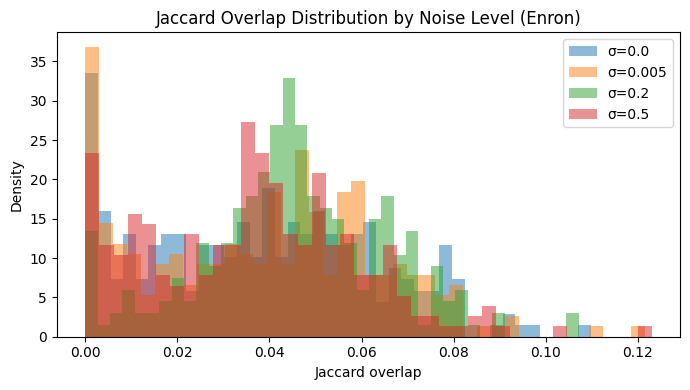

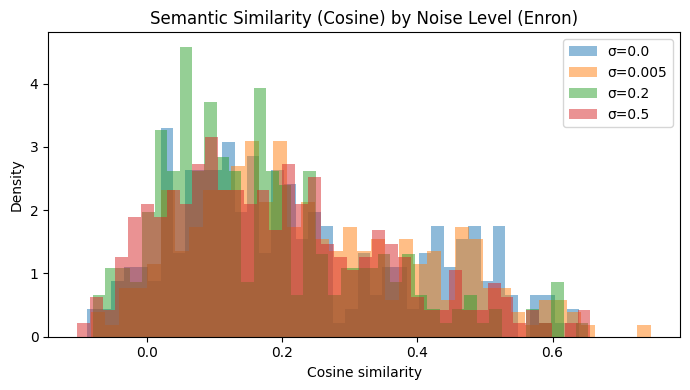

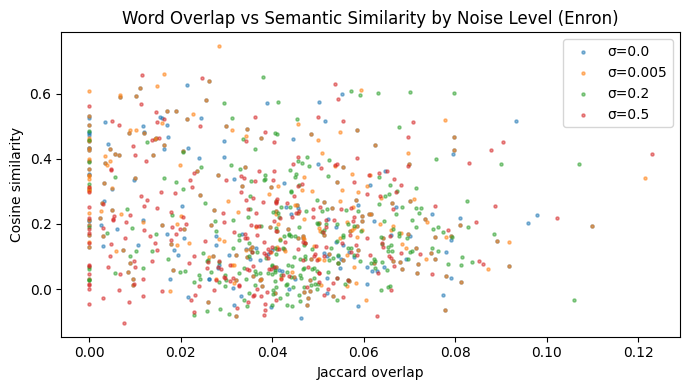

In [13]:
import os, re
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

OUT_DIR = "/content/drive/MyDrive/DiffPriv/Enron"
TITLE_SUFFIX = "Enron"

# matches:
# metrics_sigma_0.005.csv
# metrics_sigma_0.005_FIXED.csv
PAT = re.compile(r"^metrics_sigma_([0-9]+(?:\.[0-9]+)?)(?:_FIXED)?\.csv$")

files = [os.path.basename(p) for p in glob(f"{OUT_DIR}/metrics_sigma_*.csv")]

# build map: sigma -> {"fixed": path, "raw": path}
by_sigma = {}
skipped = []
for base in files:
    m = PAT.match(base)
    if not m:
        skipped.append(base)
        continue
    sigma = float(m.group(1))
    is_fixed = base.endswith("_FIXED.csv")
    by_sigma.setdefault(sigma, {})
    by_sigma[sigma]["fixed" if is_fixed else "raw"] = os.path.join(OUT_DIR, base)

if skipped:
    print("Skipping (unexpected names):", skipped)

# prefer FIXED
pairs = []
for sigma in sorted(by_sigma.keys()):
    chosen = by_sigma[sigma].get("fixed") or by_sigma[sigma].get("raw")
    pairs.append((sigma, chosen))

print("Using files:")
for sigma, fp in pairs:
    tag = "FIXED" if fp.endswith("_FIXED.csv") else "raw"
    print(f" - σ={sigma}: {os.path.basename(fp)} ({tag})")

# =========================
# 1) Load + stack
# =========================
dfs = []
for sigma, fp in pairs:
    df = pd.read_csv(fp)

    need = ["jaccard_overlap", "embedding_cosine_similarity"]
    missing = [c for c in need if c not in df.columns]
    if missing:
        raise ValueError(f"{os.path.basename(fp)} missing columns: {missing}")

    df = df[need].copy()
    df["sigma"] = sigma
    dfs.append(df)

all_df = pd.concat(dfs, ignore_index=True)
sigmas_sorted = sorted(all_df["sigma"].unique())
print("Loaded sigmas:", sigmas_sorted, "| total rows:", len(all_df))

# =========================
# 2) Comparative histograms
# =========================
bins = 40

plt.figure(figsize=(7, 4))
for s in sigmas_sorted:
    sub = all_df[all_df["sigma"] == s]
    plt.hist(sub["jaccard_overlap"], bins=bins, alpha=0.5, density=True, label=f"σ={s}")
plt.title(f"Jaccard Overlap Distribution by Noise Level ({TITLE_SUFFIX})")
plt.xlabel("Jaccard overlap")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
for s in sigmas_sorted:
    sub = all_df[all_df["sigma"] == s]
    plt.hist(sub["embedding_cosine_similarity"], bins=bins, alpha=0.5, density=True, label=f"σ={s}")
plt.title(f"Semantic Similarity (Cosine) by Noise Level ({TITLE_SUFFIX})")
plt.xlabel("Cosine similarity")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# =========================
# 3) Scatter: Jaccard vs Cosine
# =========================
scatter_df = all_df.copy()
if len(scatter_df) > 4000:
    scatter_df = scatter_df.sample(4000, random_state=42)

plt.figure(figsize=(7, 4))
for s in sigmas_sorted:
    sub = scatter_df[scatter_df["sigma"] == s]
    plt.scatter(sub["jaccard_overlap"], sub["embedding_cosine_similarity"], s=5, alpha=0.5, label=f"σ={s}")
plt.title(f"Word Overlap vs Semantic Similarity by Noise Level ({TITLE_SUFFIX})")
plt.xlabel("Jaccard overlap")
plt.ylabel("Cosine similarity")
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
import os, re
from glob import glob
import pandas as pd
from IPython.display import display

# === EDIT THIS ===
OUT_DIR = "/content/drive/MyDrive/DiffPriv/Enron"

pd.set_option("display.max_colwidth", 120)
pd.set_option("display.max_columns", 200)

# Prefer *_FIXED.csv if present for the same sigma
_METRICS_RE = re.compile(r"^metrics_sigma_([0-9]+(?:\.[0-9]+)?)(?:_FIXED)?\.csv$")
_FEAT_RE    = re.compile(r"^feature_report_sigma_([0-9]+(?:\.[0-9]+)?)(?:_FIXED)?\.csv$")

def pick_sigma_files(pattern_glob, name_re, prefer_fixed=True):
    files = [os.path.basename(p) for p in glob(os.path.join(OUT_DIR, pattern_glob))]
    by_sigma = {}
    skipped = []
    for base in files:
        m = name_re.match(base)
        if not m:
            skipped.append(base)
            continue
        sigma = float(m.group(1))
        is_fixed = base.endswith("_FIXED.csv")
        by_sigma.setdefault(sigma, {})
        by_sigma[sigma]["fixed" if is_fixed else "raw"] = os.path.join(OUT_DIR, base)

    picked = []
    for sigma in sorted(by_sigma.keys()):
        if prefer_fixed and ("fixed" in by_sigma[sigma]):
            picked.append((sigma, by_sigma[sigma]["fixed"]))
        else:
            picked.append((sigma, by_sigma[sigma].get("raw") or by_sigma[sigma].get("fixed")))

    return picked, skipped

print("OUT_DIR:", OUT_DIR)

# -------------------------
# 1) List CSVs (like Clinton printout)
# -------------------------
metric_pairs, metric_skipped = pick_sigma_files("metrics_sigma_*.csv", _METRICS_RE, prefer_fixed=True)
feat_pairs, feat_skipped     = pick_sigma_files("feature_report_sigma_*.csv", _FEAT_RE, prefer_fixed=True)

summary_file = os.path.join(OUT_DIR, "summary_across_sigmas.csv")

print("\nFound metrics:", len(metric_pairs))
for sigma, fp in metric_pairs:
    print(" -", os.path.basename(fp))

print("\nFound feature reports:", len(feat_pairs))
for sigma, fp in feat_pairs:
    print(" -", os.path.basename(fp))

print("\nSummary exists:", os.path.exists(summary_file), "|", os.path.basename(summary_file))

if metric_skipped:
    print("\n(ignored weird metric filenames)")
    for b in sorted(metric_skipped):
        print(" -", b)

if feat_skipped:
    print("\n(ignored weird feature-report filenames)")
    for b in sorted(feat_skipped):
        print(" -", b)

# -------------------------
# 2) Show + stats for metrics files (same vibe)
# -------------------------
metrics_summary_rows = []

for sigma, fp in metric_pairs:
    df = pd.read_csv(fp)

    print("\n" + "="*90)
    print(f"METRICS σ={sigma}  |  rows={len(df)}  cols={len(df.columns)}  file={os.path.basename(fp)}")
    print("="*90)

    display(df.head(5))

    cols = [c for c in ["jaccard_overlap", "embedding_cosine_similarity"] if c in df.columns]
    if cols:
        print("\n.describe() on key metrics:")
        display(df[cols].describe().T)

        metrics_summary_rows.append({
            "sigma": float(sigma),
            "n": len(df),
            "mean_jaccard": df["jaccard_overlap"].mean() if "jaccard_overlap" in df else None,
            "std_jaccard": df["jaccard_overlap"].std() if "jaccard_overlap" in df else None,
            "p50_jaccard": df["jaccard_overlap"].median() if "jaccard_overlap" in df else None,
            "mean_cosine": df["embedding_cosine_similarity"].mean() if "embedding_cosine_similarity" in df else None,
            "std_cosine": df["embedding_cosine_similarity"].std() if "embedding_cosine_similarity" in df else None,
            "p50_cosine": df["embedding_cosine_similarity"].median() if "embedding_cosine_similarity" in df else None,
        })

# consolidated metrics summary
if metrics_summary_rows:
    metrics_summary = pd.DataFrame(metrics_summary_rows).sort_values("sigma").reset_index(drop=True)
    print("\n" + "#"*90)
    print("CONSOLIDATED METRICS SUMMARY (by sigma)")
    print("#"*90)
    display(metrics_summary)

# -------------------------
# 3) Feature report preview (if present)
# -------------------------
if feat_pairs:
    for sigma, fp in feat_pairs:
        df = pd.read_csv(fp)
        print("\n" + "="*90)
        print(f"FEATURE REPORT σ={sigma}  |  rows={len(df)}  cols={len(df.columns)}  file={os.path.basename(fp)}")
        print("="*90)
        display(df.head(5))
else:
    print("\nNo feature_report_sigma_*.csv found.")

# -------------------------
# 4) Show summary_across_sigmas.csv if it exists
# -------------------------
if os.path.exists(summary_file):
    print("\n" + "#"*90)
    print("summary_across_sigmas.csv")
    print("#"*90)
    display(pd.read_csv(summary_file))
else:
    print("\nNo summary_across_sigmas.csv found (you can regenerate it from metrics files if you want).")


OUT_DIR: /content/drive/MyDrive/DiffPriv/Enron

Found metrics: 4
 - metrics_sigma_0.0_FIXED.csv
 - metrics_sigma_0.005_FIXED.csv
 - metrics_sigma_0.2_FIXED.csv
 - metrics_sigma_0.5_FIXED.csv

Found feature reports: 4
 - feature_report_sigma_0.0.csv
 - feature_report_sigma_0.005.csv
 - feature_report_sigma_0.2.csv
 - feature_report_sigma_0.5.csv

Summary exists: False | summary_across_sigmas.csv

METRICS σ=0.0  |  rows=250  cols=4  file=metrics_sigma_0.0_FIXED.csv


,original,synthetic,jaccard_overlap,embedding_cosine_similarity
0,"From: dave.guzman@fluor.com\nTo: mark.guzman@enron.com\nCc:\nBcc:\nSubject: Re: status\n\nhey Mark,\nyes, cita had a...",", and have been unable to get back in contact with my family. It's been really hard to keep up with all of this, an...",0.069686,0.170255
1,From: dan.hyvl@enron.com\nTo: voinorml@bp.com\nCc:\nBcc:\nSubject: RE: FW: Assignment of transaction no. 1\n\nI thou...,"My husband and I have been married for 11 years. We have two small children, ages 5 and 3. They are very happy and...",0.058824,-0.052114
2,From: faretracker_020273@expedia.customer-email.com\nTo: pkeavey@ect.enron.com\nCc:\nBcc:\nSubject: Plan your summer...,"AGE][IMAGE_SIZE=3]\t \r\n \t\t \t[IMAGEGRAM]\t\t [IMAGEPAD] \t Dear Mr. [REDACTED], I am writing to you to exp...",0.017588,0.031384
3,From: richard.sanders@enron.com\nTo: gail.brownfeld@enron.com\nCc:\nBcc:\nSubject: Re: Sempra: Preservation of docum...,"enron.com'\nSubject: \n\nI'm sorry, I didn't realise you were in the office. I'm sorry. It's just that I've been\n...",0.048458,0.477117
4,"From: erwollam@hotmail.com\nTo:\nCc:\nBcc:\nSubject: lease report\n\nDeer All,\nattached is the 2001 game log (to da...","'s in the same building as my old place, so I'm not sure if I'll be able to stay there. However, since I'm moving, ...",0.052478,0.109158



.describe() on key metrics:


,count,mean,std,min,25%,50%,75%,max
jaccard_overlap,250.0,0.038151,0.025202,0.000000,0.016973,0.039268,0.056503,0.109827
embedding_cosine_similarity,250.0,0.226482,0.177949,-0.089092,0.090623,0.189498,0.375748,0.639465



METRICS σ=0.005  |  rows=250  cols=4  file=metrics_sigma_0.005_FIXED.csv


,original,synthetic,jaccard_overlap,embedding_cosine_similarity
0,"From: dave.guzman@fluor.com\nTo: mark.guzman@enron.com\nCc:\nBcc:\nSubject: Re: status\n\nhey Mark,\nyes, cita had a...",", and have been unable to get back in contact with my family. It's been really hard to keep up with all of this, an...",0.069686,0.170255
1,From: dan.hyvl@enron.com\nTo: voinorml@bp.com\nCc:\nBcc:\nSubject: RE: FW: Assignment of transaction no. 1\n\nI thou...,"My husband and I have been married for 11 years. We have two small children, ages 5 and 3. They are very loving an...",0.060465,-0.032035
2,From: faretracker_020273@expedia.customer-email.com\nTo: pkeavey@ect.enron.com\nCc:\nBcc:\nSubject: Plan your summer...,"AGE][IMAGE_SIZE=3]\t \r\n \t\t \t[IMAGEGRAM]\t\t [IMAGEPAD] \t Dear Mr. [REDACTED], I am writing to you to exp...",0.017588,-0.006099
3,From: richard.sanders@enron.com\nTo: gail.brownfeld@enron.com\nCc:\nBcc:\nSubject: Re: Sempra: Preservation of docum...,"enron.com'\nSubject: \n\nI'm sorry, I didn't realise you were in the office. I'm sorry. It's just that I've been\n...",0.048458,0.475612
4,"From: erwollam@hotmail.com\nTo:\nCc:\nBcc:\nSubject: lease report\n\nDeer All,\nattached is the 2001 game log (to da...","'s in the same building as my old place, so I'm not sure if I'll be able to stay there. However, since I'm moving, ...",0.052478,0.109158



.describe() on key metrics:


,count,mean,std,min,25%,50%,75%,max
jaccard_overlap,250.0,0.038474,0.025484,0.000000,0.016251,0.040932,0.057419,0.121547
embedding_cosine_similarity,250.0,0.241738,0.170523,-0.083278,0.116475,0.204738,0.368055,0.746131



METRICS σ=0.2  |  rows=250  cols=4  file=metrics_sigma_0.2_FIXED.csv


,original,synthetic,jaccard_overlap,embedding_cosine_similarity
0,"From: dave.guzman@fluor.com\nTo: mark.guzman@enron.com\nCc:\nBcc:\nSubject: Re: status\n\nhey Mark,\nyes, cita had a...","be there from 11:00 a.m. to 1:00 p.m., and I'm \nlooking forward to seeing all of you. If you have any questions, j...",0.052265,0.346854
1,From: dan.hyvl@enron.com\nTo: voinorml@bp.com\nCc:\nBcc:\nSubject: RE: FW: Assignment of transaction no. 1\n\nI thou...,"'m not sure when I'll be able to get back in touch with you, but I'll let you know as soon as I hear from you.\n\nTh...",0.069767,0.093862
2,From: faretracker_020273@expedia.customer-email.com\nTo: pkeavey@ect.enron.com\nCc:\nBcc:\nSubject: Plan your summer...,03.mail.aOL.com [172.18.147.3]) by air-yyh01.mail-daemon (v77_r1.21) with ESMTP id MAILINYH1B9 for <david.forster@enron,0.010178,0.117190
3,From: richard.sanders@enron.com\nTo: gail.brownfeld@enron.com\nCc:\nBcc:\nSubject: Re: Sempra: Preservation of docum...,"industry. Enron is a great company, and I have enjoyed working there. However, I have come to the conclusion that ...",0.065789,0.320167
4,"From: erwollam@hotmail.com\nTo:\nCc:\nBcc:\nSubject: lease report\n\nDeer All,\nattached is the 2001 game log (to da...","not sure when I'll be able to get back to work, but I'll let you know as soon as I do. \n\nMy roommates are very su...",0.064706,0.285942



.describe() on key metrics:


,count,mean,std,min,25%,50%,75%,max
jaccard_overlap,250.0,0.045419,0.019951,0.000000,0.034728,0.044586,0.057790,0.107143
embedding_cosine_similarity,250.0,0.170777,0.153770,-0.080236,0.056602,0.132130,0.247461,0.652909



METRICS σ=0.5  |  rows=250  cols=4  file=metrics_sigma_0.5_FIXED.csv


,original,synthetic,jaccard_overlap,embedding_cosine_similarity
0,"From: dave.guzman@fluor.com\nTo: mark.guzman@enron.com\nCc:\nBcc:\nSubject: Re: status\n\nhey Mark,\nyes, cita had a...","email from us, please close this message or modify your preferences at the bottom of this email.\n\nTo unsubscribe f...",0.056537,0.028178
1,From: dan.hyvl@enron.com\nTo: voinorml@bp.com\nCc:\nBcc:\nSubject: RE: FW: Assignment of transaction no. 1\n\nI thou...,"sent to the following recipients:\n\nSubject: \n\nHello,\n\nI hope you are doing well. I hope you have had a good ...",0.061033,0.350963
2,From: faretracker_020273@expedia.customer-email.com\nTo: pkeavey@ect.enron.com\nCc:\nBcc:\nSubject: Plan your summer...,"from [192.152.140.1] by mailman.enron.com (Lotus Domino Release 5.0.0) with ESMTP id MAILMAN-5-0-0; Mon, 17 Dec 2001...",0.009975,0.069378
3,From: richard.sanders@enron.com\nTo: gail.brownfeld@enron.com\nCc:\nBcc:\nSubject: Re: Sempra: Preservation of docum...,up a new office in Houston. We are currently looking for a full-time person to join our team. I am currently inter...,0.084444,0.206088
4,"From: erwollam@hotmail.com\nTo:\nCc:\nBcc:\nSubject: lease report\n\nDeer All,\nattached is the 2001 game log (to da...","CLIENT NAME] [CLIENT ADDRESS] \n\n\n[IMAGE]\n \n \n\nDear Client,\n\nI am writing to you to inform you that I hav...",0.020468,0.220151



.describe() on key metrics:


,count,mean,std,min,25%,50%,75%,max
jaccard_overlap,250.0,0.036602,0.022709,0.000000,0.017918,0.037114,0.051336,0.122995
embedding_cosine_similarity,250.0,0.191823,0.161804,-0.103791,0.068060,0.168950,0.290302,0.656186



##########################################################################################
CONSOLIDATED METRICS SUMMARY (by sigma)
##########################################################################################


,sigma,n,mean_jaccard,std_jaccard,p50_jaccard,mean_cosine,std_cosine,p50_cosine
0,0.000,250,0.038151,0.025202,0.039268,0.226482,0.177949,0.189498
1,0.005,250,0.038474,0.025484,0.040932,0.241738,0.170523,0.204738
2,0.200,250,0.045419,0.019951,0.044586,0.170777,0.153770,0.132130
3,0.500,250,0.036602,0.022709,0.037114,0.191823,0.161804,0.168950



FEATURE REPORT σ=0.0  |  rows=250  cols=12  file=feature_report_sigma_0.0.csv


,sigma,jaccard_overlap,embedding_cosine_similarity,leaked_email_any,leaked_phone_any,leaked_name_any,leaked_address_any,syn_emails_regex,syn_phones_regex,retained_category,retained_topic,retained_project
0,0.0,0.000000,0.033207,False,False,False,False,[],[],[],[],[]
1,0.0,0.000000,0.031987,False,False,False,False,[],[],[],[],[]
2,0.0,0.026699,0.110225,False,False,False,False,[],[],[],[],[]
3,0.0,0.000000,0.096668,False,False,False,False,[],[],[],[],[]
4,0.0,0.000000,0.094279,False,False,False,False,[],[],[],[],[]



FEATURE REPORT σ=0.005  |  rows=250  cols=12  file=feature_report_sigma_0.005.csv


,sigma,jaccard_overlap,embedding_cosine_similarity,leaked_email_any,leaked_phone_any,leaked_name_any,leaked_address_any,syn_emails_regex,syn_phones_regex,retained_category,retained_topic,retained_project
0,0.005,0.000000,0.033207,False,False,False,False,[],[],[],[],[]
1,0.005,0.069124,-0.043687,False,False,False,False,[],[],[],[],[]
2,0.005,0.000000,0.036764,False,False,False,False,[],[],[],[],[]
3,0.005,0.000000,0.096668,False,False,False,False,[],[],[],[],[]
4,0.005,0.028653,0.173850,False,False,False,False,[],[],[],[],[]



FEATURE REPORT σ=0.2  |  rows=250  cols=12  file=feature_report_sigma_0.2.csv


,sigma,jaccard_overlap,embedding_cosine_similarity,leaked_email_any,leaked_phone_any,leaked_name_any,leaked_address_any,syn_emails_regex,syn_phones_regex,retained_category,retained_topic,retained_project
0,0.2,0.000000,0.033207,False,False,False,False,[],[],[],[],[]
1,0.2,0.000000,0.031987,False,False,False,False,[],[],[],[],[]
2,0.2,0.024272,0.067557,False,False,False,False,[],[],[],[],[]
3,0.2,0.024793,0.289747,False,False,False,False,[],[],[],[],[]
4,0.2,0.000000,0.094279,False,False,False,False,[],[],[],[],[]



FEATURE REPORT σ=0.5  |  rows=250  cols=12  file=feature_report_sigma_0.5.csv


,sigma,jaccard_overlap,embedding_cosine_similarity,leaked_email_any,leaked_phone_any,leaked_name_any,leaked_address_any,syn_emails_regex,syn_phones_regex,retained_category,retained_topic,retained_project
0,0.5,0.030000,0.078125,False,False,False,False,[],[],[],[],[]
1,0.5,0.000000,0.031987,False,False,False,False,[],[],[],[],[]
2,0.5,0.000000,0.036764,False,False,False,False,[],[],[],[],[]
3,0.5,0.030043,0.205598,False,False,False,False,[],[],[],[],[]
4,0.5,0.028986,0.251455,False,False,False,False,[],[],[],[],[]



No summary_across_sigmas.csv found (you can regenerate it from metrics files if you want).
